# Retención proactiva de clientes bancarios

## DM EyF 2024 - UBA

## Experimento combinando Árboles con Redes Neuronales

Comisión: lunes

Alumno: Santiago Tedoldi


## Motivación

La supremacía de los modelos basados en árboles para la resolución de problemas con datos tabulares podría ser cuestionada a la luz del desarrollo de modelos de IA cada vez más complejos y sofisticados. Estos nuevos modelos han demostrado resolver con éxito problemas con datos no tabulados, como imágenes, lenguaje e incluso en problemas multimodelas.

Las redes convolucionales, en imágenes, y los transformers, principalmente para texto, pueden considerarse el estado del arte para muchos problemas complejos. Ahora bien, ¿es posible aprovechar estos desarrollos en problemas como la retención proactiva de clientes?

En mi trabajo, durante el desarrollo de modelos analíticos de riesgo aduanero, tuve la oportunidad de probar arquitecturas que combinan árboles con redes neuronales y mecanismos de atención. Los resultados obtenidos para esos casos son prometedores, aunque ningún modelo semejante haya entrado aún en producción.

En este experimento pretendo ensayar un modelo que combine un bosque pre-entrenado (GBDTs), idéntico a los optimizados para el problema de retención de clientes bancarios, una capa de embedding que codifica las hojas activas (cross-features) por cada cliente. Esta combinación de bosque y capa de embedding recibe el nombre de **Tree-based Cross-Feature Embedding**.

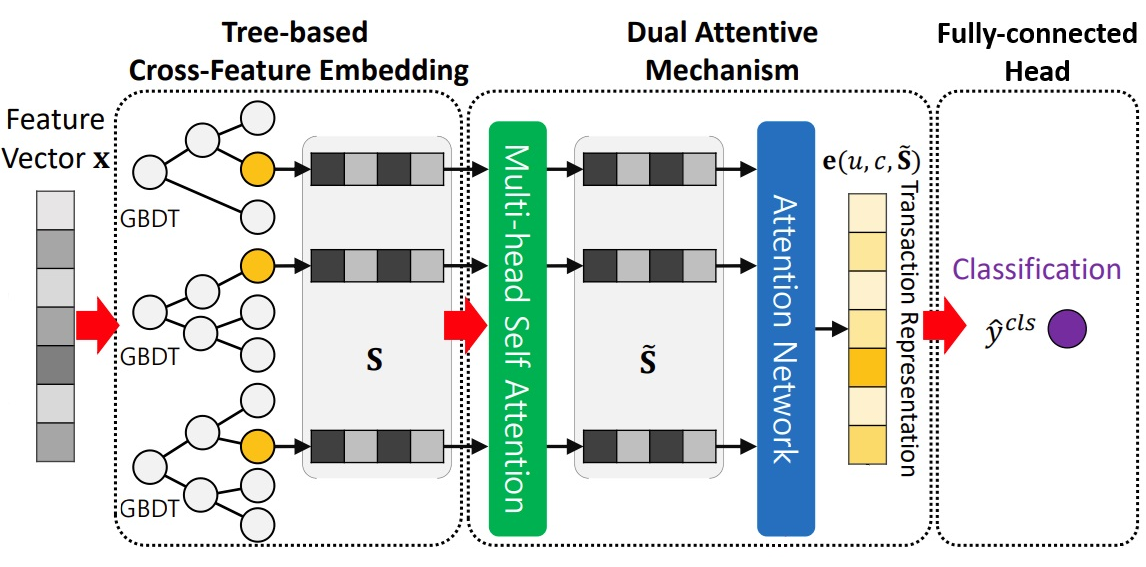

Opcionalmente, la representación de cada hoja activa (cross-feature) se procesa en una capa de self-attention con 4 cabezas busca adaptarlas según el "contexto" (otras hojas activas para el mismo cliente).

Tras el proceso de self-attention, las representaciones de las 100 hojas activas (cross-feature) se agregan (por ejemplo, sumándose) y normalizan. Otra matriz de atención, también opcional, que bien podría permitir el "cruce" con otros embeddings significativos para el problema, se aplica para obtener una representación latente de cada cliente.

Al final, un arreglo fully-connected termina de procesar cada caso, usa su representación latente del cliente para llegar a la seudo-probabilidad de su baja.

## Bibliografía

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need

Sundong Kim, Yu-Che Tsai, Karandeep Singh, Yeonsoo Choi, Etim Ibok, Cheng-Te Li, Meeyoung Cha. 2020. DATE: Dual Attentive Tree-aware Embedding for Customs Fraud Detection

## Dependencia

In [1]:
# Importar las librerías necesarias
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

## Directorios

In [2]:
datos = 'datos'
optimizacion = 'optimizacion'
modelos = 'modelos'
resultados = 'resultados'

## Condiciones de entrenamiento

Entrenamos con la mejor optimización posible, sobre el último més disponible.

Ya tenemos en nuestras variables, algunas variables históricas según el feature engineering aplicado.

In [3]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

In [4]:
max_jobs = os.cpu_count() - 6

## Ensamble

XGBoost + Redes neuronales

Usando el XGBoost optimizado para la competencia 01, vamos a desarrollar un modelo de ensamble con redes neuronales y mecanismos de atención.

### 1. XGBoost re-entrenado

Datos

In [5]:
dataset_file = 'competencia_01_brandoni_fe_agr_3.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

# data cleansing + data drifting
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

C:\Users\santt\AppData\Local\Temp\ipykernel_20112\217547193.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


Target ternaria

In [6]:
target_multi = 'clase_ternaria'

X = data[data['foto_mes'] == mes_train]
y = X[target_multi]
X = X.drop(columns=[target_multi])

In [7]:
# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

y = y.map(label_mapping)

y.value_counts()

clase_ternaria
0    161919
2      1189
1       982
Name: count, dtype: int64

Target binaria

In [8]:
y_bin = pd.Series(
                np.where(y == 2, 1, 0),
                name='clase_binaria',
                index=y.index
                )

y_bin.value_counts()

clase_binaria
0    162901
1      1189
Name: count, dtype: int64

Limpiando sets

In [9]:
# Identificar y eliminar columnas con todos los valores NaN
cols_with_all_nan = X.columns[X.isna().all()]
print("Columnas en X con todos los valores NaN:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X = X.drop(columns=to_drop)

Columnas en X con todos los valores NaN: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Split del train para tomar una porción para validación y test

Previa imputación y aplicación de SMOTE para balancer las clases y mejorar el aprendizaje del dl_att model

In [10]:
from sklearn.model_selection import train_test_split

# Split entre train y test (validación)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    # y, # ternaria
                                                    y_bin, # binaria
                                                    test_size=0.1,
                                                    # stratify=y,
                                                    stratify=y_bin, 
                                                    random_state=semillas[1])

y_train = y_train.values
y_test = y_test.values

In [11]:
len(y_train)

147681

Training XGB model

In [12]:
# parametros de la optimización, para problema binario

opt_params = {
    'objective': 'binary:logistic', #'multi:softprob',
    'base_score': None,
    'booster': None,
    'callbacks': None,
    'colsample_bylevel': None,
    'colsample_bynode': None,
    'colsample_bytree': 0.5429812768188057,
    'device': None,
    'early_stopping_rounds': None,
    'enable_categorical': False,
    'eval_metric': None,
    'feature_types': None,
    'gamma': 2.9208841946871176,
    'grow_policy': None,
    'importance_type': None,
    'interaction_constraints': None,
    'learning_rate': None,
    'max_bin': None,
    'max_cat_threshold': None,
    'max_cat_to_onehot': None,
    'max_delta_step': None,
    'max_depth': None,
    'max_leaves': 19,
    'min_child_weight': 7,
    'missing': np.nan,
    'monotone_constraints': None,
    'multi_strategy': None,
    'n_estimators': None,
    'n_jobs': None,
    'num_parallel_tree': None,
    'random_state': None,
    'reg_alpha': None,
    'reg_lambda': None,
    'sampling_method': None,
    'scale_pos_weight': 8.669078758370219,
    'subsample': 0.9416959858943643,
    'tree_method': None,
    'validate_parameters': None,
    'verbosity': None,
    'eta': 0.11537876667197919,
    'lambda': 7.226815448281549,
    'alpha': 0.5929685712726126
    }

# instancia con mejores parámetros
xgb_clf = XGBClassifier(**opt_params, seed=semillas[1])

# entreno
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=0.5929685712726126, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5429812768188057, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.11537876667197919, eval_metric=None, feature_types=None,
              gamma=2.9208841946871176, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=7.226815448281549,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=19, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [13]:
# Get number of trees in the model
num_trees = xgb_clf.get_booster().num_boosted_rounds()
print("Number of trees:", num_trees)

# Get the model parameters
params = xgb_clf.get_params()
print("Model Parameters:", params)

Number of trees: 100
Model Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5429812768188057, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 2.9208841946871176, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': 19, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 8.669078758370219, 'subsample': 0.9416959858943643, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.11

Balanceando datasets train y test con SMOTE

In [14]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

# Define the SMOTE instance
smote = SMOTE(random_state=semillas[1])

# Fit and resample X_train and y_train
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
X_test_over, y_test_over = smote.fit_resample(X_test, y_test)

In [15]:
smote_frac = y_train.sum()/y_train_over.sum()

In [16]:
# evaluation Libraries
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

def ganancia(y_test, y_pred_prob, prop=1, threshold=0.025, ganancia_acierto=273000, costo_estimulo=7000):

  @np.vectorize
  def ganancia_row(predicted, actual, thr=threshold):
    return  (predicted >= thr) * (ganancia_acierto if actual == 1 else -costo_estimulo) # 1 == "BAJA+2"

  return ganancia_row(y_pred_prob, y_test).sum() / prop

def find_best_threshold(y_pred_prob, y_test, best_thresh = None, prop=1):
    """
    This function is to find the best threshold to determine "to inspect" or "not".
    We assume that we inspect only the imports where predicted probability of fraud is above the threshold.

    dtype model: xgboost.sklearn.XGBClassifier
    dtype x_list: list or array
    dtype y_test: np.array
    dtype best_thresh: float
    rtype best_f1: float
    """
  
    threshold_list = np.arange(0.01, 0.6, 0.01)
    # Set an initial value of best threshold.
    best_f1 = 0
    
    # If best_thresh is set as "None", this function is to find the best_thresh as well as best_f1 
    if best_thresh == None:
        for th in threshold_list:
            y_pred_label = (y_pred_prob > th)*1 
            f_score = f1_score(y_test, y_pred_label)
            if f_score > best_f1:
                best_f1 = f_score
                best_thresh = th 
        return best_thresh, best_f1, roc_auc_score(y_test, y_pred_prob)
    
    # If best_thresh is set as a certain number, this function is to calculate its f1 score.
    else:
        y_pred_label = (y_pred_prob > best_thresh)*1 
        best_f1 = f1_score(y_test, y_pred_label)
        gain = ganancia(y_test, y_pred_prob, threshold = best_thresh, prop=prop)

    return best_f1, roc_auc_score(y_test, y_pred_prob), gain

Testeo

In [17]:
# Evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb_clf.predict_proba(X_test)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(y_test, test_pred)

# Find the best threshold
xgb_threshold, _, _ = find_best_threshold(xgb_clf.predict_proba(X_test)[:,1], y_test)
# Calculate the best f1 score
xgb_f1, roc_auc, gain  = find_best_threshold(xgb_clf.predict_proba(X_test)[:,1], y_test, best_thresh = xgb_threshold)
print("AUC = %.4f, F1-score = %.4f, Threshold = %.2f, Gain = %.0f" % (xgb_auc, xgb_f1, xgb_threshold, gain))

------Evaluating xgboost model------
AUC = 0.9158, F1-score = 0.2624, Threshold = 0.59, Gain = 7406000


Ganancia con threshold 0.025

In [18]:
ganancia(y_train, xgb_clf.predict_proba(X_train)[:,1], prop=0.9, threshold=0.025) # proportion según el split del test

80484444.44444445

In [19]:
ganancia(y_test, xgb_clf.predict_proba(X_test)[:,1], prop=0.1, threshold=0.025) # proportion según el split del test

58800000.0

Guardado del modelo XGBoost

In [20]:
import joblib

xgb_clf_path = 'modelos/xgb_classifier_model.pkl'

# Save the model
joblib.dump(xgb_clf, xgb_clf_path)

['modelos/xgb_classifier_model.pkl']

### 2. Funciones de ensamble

**process_lead_idx** function

In [21]:
def process_leaf_idx(X_leaves): 
    """
    This function is to convert the output of XGBoost model to the input of DATE model.
    For an individual import, the output of XGBoost model is a list of leaf index of multiple trees.
    eg. [1, 1, 10, 9, 30, 30, 32, ... ]
    How to distinguish "node 1" of the first tree from "node 1" of the second tree?
    How to distinguish "node 30" of the fifth tree from "node 30" of the sixth tree?
    This function is to assign unique index to every leaf node in all the trees. 
    
    This function returns;
    - lists of unique leaf index;
    - total number of unique leaf nodes; and
    - a reference table (dictionary) composed of "unique leaf index", "tree id", "(previous) leaf index".
    
    dtype X_leaves: np.array
    rtype leaves: list
    rtype total_leaves: int
    rtype new_leaf_index: dict 
    """
    leaves = X_leaves.copy()
    new_leaf_index = dict() # Dictionary to store leaf index
    total_leaves = 0
    for c in range(X_leaves.shape[1]): # Iterate for each column (i.e. 100 trees)
        column = X_leaves[:,c]
        unique_vals = list(sorted(set(column)))
        new_idx = {v:(i+total_leaves) for i,v in enumerate(unique_vals)}
        for i,v in enumerate(unique_vals):
            leaf_id = i+total_leaves
            new_leaf_index[leaf_id] = {c:v}
        leaves[:,c] = [new_idx[v] for v in column]
        total_leaves += len(unique_vals)
        
    assert leaves.ravel().max() == total_leaves - 1
    return leaves,total_leaves,new_leaf_index

**fgsm_attack** function

This function is to generate adversarial samples.

In [22]:
def fgsm_attack(model, loss, images, labels, eps):
    """
    Generate adversarial examples
    
    dtype model: torch.nn.parallel.data_parallel.DataParallel
    dtype loss: torch.nn.modules.loss.BCELoss
    dtype images: torch.Tensor
    dtype labels: torch.Tensor
    dtype eps: float
    rtype attack_images: torch.Tensor
    """
    
    images = Variable(images, requires_grad=True)
    outputs = model.module.pred_from_hidden(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    attack_images = images + eps * images.grad.sign()
    
    return attack_images

**metrics** function

This is the function which generates metrics to evaluate the performance of the model.  

For date model, we will calculate the metrics of evaluation for each group of 1%, 2%, 5%, and 10% suspicious transactions suggested by the model.

In [23]:
def metrics(y_prob, xgb_testy, best_thresh=None, prop=1):
    """
    Generate metrics for evaluation

    dtype y_prob: np.array
    dtype xgb_testy: np.array
    dtype best_thresh: float64
    rtype overall_f1: float64
    rtype auc: float64
    rtype pr: list
    rtype re: list
    rtype f: list
    rtype gain: float64
    """

    if best_thresh is None:
        best_thresh, overall_f1, auc = find_best_threshold(y_prob, xgb_testy, best_thresh)
        gain = ganancia(xgb_testy, y_prob, threshold=best_thresh, prop=prop)
    else:
        overall_f1, auc, gain = find_best_threshold(y_prob, xgb_testy, best_thresh)

    pr, re, f = [], [], []
    for i in [99, 98, 95, 90]:
        threshold = np.percentile(y_prob, i)
        y_pred_label = (y_prob > threshold).astype(int)

        # Check for no positive predictions
        if y_pred_label.sum() == 0:
            precision = 0.0
            recall = 0.0
            f1 = 0.0
        else:
            precision = precision_score(xgb_testy, y_pred_label, zero_division=0)
            recall = recall_score(xgb_testy, y_pred_label, zero_division=0)
            f1 = f1_score(xgb_testy, y_pred_label, zero_division=0)

        pr.append(precision)
        re.append(recall)
        f.append(f1)

    return overall_f1, auc, pr, re, f, gain

### 3. Leaf nodes of each import from XGB model**

Get output values from the XGBoost model and convert them to the input for NN

In [24]:
# Get leaf index from xgboost model 
X_train_leaves = xgb_clf.apply(X_train_over) #apply: Return the predicted leaf every tree for each sample.
# X_valid_leaves = xgb_clf.apply(X_val)
X_test_leaves = xgb_clf.apply(X_test_over)
train_rows = X_train_leaves.shape[0]

In [25]:
# Preprocess
train_rows = X_train_over.shape[0]
test_rows = X_test_over.shape[0] + train_rows

# Convert output values of the XGBoost model to the input form of the DATE model.
X_leaves = np.concatenate((X_train_leaves, X_test_leaves), axis=0) # Make sure the dimensionality

transformed_leaves, leaf_num, new_leaf_index = process_leaf_idx(X_leaves)

train_leaves, test_leaves = transformed_leaves[:train_rows],\
                                          transformed_leaves[train_rows:]

In [26]:
transformed_leaves

array([[  10.,   20.,   40., ..., 1849., 1856., 1880.],
       [   7.,   25.,   45., ..., 1838., 1866., 1876.],
       [   7.,   25.,   45., ..., 1851., 1868., 1883.],
       ...,
       [   7.,   25.,   44., ..., 1852., 1866., 1883.],
       [   7.,   25.,   39., ..., 1851., 1866., 1885.],
       [   7.,   25.,   44., ..., 1851., 1866., 1885.]], dtype=float32)

In [27]:
len(transformed_leaves)

325802

In [28]:
len(train_leaves)

293222

In [29]:
len(test_leaves)

32580

Seteo de semilla

In [30]:
import torch
import torch.utils.data as Data
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas múltiples GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(semillas[1])

### 4. Convert data to tensor

Tensor is a collection of numbers with specific shape (dimension)

In [31]:
# Convert to torch type
train_leaves = torch.tensor(train_leaves).long()
test_leaves = torch.tensor(test_leaves).long()

# cls data
train_label_cls = torch.tensor(y_train_over).float()
test_label_cls = torch.tensor(y_test_over).float()

# Create dataset 
train_dataset = Data.TensorDataset(train_leaves, train_label_cls)
test_dataset = Data.TensorDataset(test_leaves, test_label_cls)

Data loader

In [32]:
# Create dataloader
batch_size = 512
train_loader = Data.DataLoader(
    dataset=train_dataset,     
    batch_size=batch_size,      
    shuffle=True,               
)

test_loader = Data.DataLoader(
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

### 5. Construcción del modelo

In [33]:
# !pip install torch-multi-head-attention

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_multi_head_attention import MultiHeadAttention
from torch.autograd import Variable
import argparse

Attención

In [35]:
class Attention(nn.Module):
    """
    Attention sends all outputs of the encoder to the decoder, and at each time step, 
    the memory cell of the decoder calculates the sum of the weights from all encoder outputs 
    to determine which data to focus more on.
    """
    def __init__(self,dim,hidden,aggregate="sum"):
        super(Attention, self).__init__()
        self.attention_matrix = nn.Linear(dim, hidden)
        self.project_weight = nn.Linear(hidden*2, hidden)
        self.h = nn.Parameter(torch.rand(hidden,1))
        self.agg_type = aggregate
        
    def forward(self, query, key): # Query: 256 X 16, # key: 256 X 100 X 16, # Assume key==value
        dim = query.size(-1) # 16 (n_embedding_dimension)
        batch = key.size(0) # 256 (batch_size = n_observation in a batch)
        time_step = key.size(1) # 100 (n_trees from xgboot model)
        
        # Concate input query and key 
        query = query.view(batch, 1, dim) # View = reshape: (256X16) -> (256X1X16)
        query = query.expand(batch, time_step, -1) # Expand to the same dimension: (256X1X16) -> (256X100X16)
        cat_vector = torch.cat((query, key), dim=-1) # (256X100X32)
        
        # Project to single value
        project_vector = self.project_weight(cat_vector) 
        project_vector = torch.relu(project_vector)
        attention_alpha = torch.matmul(project_vector, self.h)
        attention_weight = torch.softmax(attention_alpha, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = key * attention_weight
        
        # Aggregate leaves
        if self.agg_type == "max":
            attention_vec, _ = torch.max(attention_vec, dim=1)
        elif self.agg_type =="mean":
            attention_vec = torch.mean(attention_vec, dim=1)
        elif self.agg_type =="sum":
            attention_vec = torch.sum(attention_vec, dim=1)
        return attention_vec, attention_weight

Ensamble DMEyF

Con normalización extra y agregando el cálculo de ganancia

In [36]:
class DMEyF(nn.Module):
    """
    Esta es la clase para crear la estructura completa del modelo DATE
    """
    def __init__(self, max_leaf, dim, head_num=4, act="relu", 
                 device="cuda", use_self=True, use_att=True, agg_type="mean",
                 threshold=0.025, ganancia_acierto=273000, costo_estimulo=-7000):
        
        super(DMEyF, self).__init__()
        self.d = dim
        self.device = device
        if act == "relu":
            self.act = nn.LeakyReLU()
        self.use_self = use_self
        self.use_att = use_att
        self.agg_type = agg_type
        self.threshold = threshold
        self.ganancia_acierto = ganancia_acierto
        self.costo_estimulo = costo_estimulo

        # Capas de embedding
        self.leaf_embedding = nn.Embedding(max_leaf, dim)

        # Capas de atención
        self.attention_block = Attention(dim, dim, self.agg_type).to(device)
        self.self_att = MultiHeadAttention(dim, head_num).to(device)

        # Capas de normalización para las salidas de atención
        self.layer_norm_self_att = nn.LayerNorm(dim)
        self.layer_norm_att_block = nn.LayerNorm(dim)

        # Capas ocultas y de salida con normalización
        self.hidden1 = nn.Linear(dim, 2*dim)
        self.hidden2 = nn.Linear(2*dim, dim)
        # self.hidden3 = nn.Linear(dim, dim)
        self.output_cls_layer = nn.Linear(dim, 1)
    
    def forward(self, feature):
        # Embedding de leaf_id
        leaf_vectors = self.leaf_embedding(feature)
        
        # Primera atención: Multi-Head Self-Attention
        if self.use_self:
            leaf_vectors = self.self_att(leaf_vectors, leaf_vectors, leaf_vectors)
            # Normalización después de self_att
            leaf_vectors = self.layer_norm_self_att(leaf_vectors)
        
        if self.use_att:
            # Computar la media de leaf_vectors para obtener query_vector
            query_vector = torch.mean(leaf_vectors, dim=1)  # (batch_size, dim)
            # Segunda atención: Atención con un vector de consulta propio
            set_vector, self.attention_w = self.attention_block(query_vector, leaf_vectors)
            # Normalización después de attention_block
            set_vector = self.layer_norm_att_block(set_vector)
        else:
            # Agregar leaves
            if self.agg_type == "max":
                set_vector, _ = torch.max(leaf_vectors, dim=1)
            elif self.agg_type == "mean":
                set_vector = torch.mean(leaf_vectors, dim=1)
            elif self.agg_type == "sum":
                set_vector = torch.sum(leaf_vectors, dim=1)

            # Normalización del set_vector si no se usa atención
            set_vector = self.layer_norm_att_block(set_vector)
    
        # Pasar por las capas ocultas con activaciones y normalización
        hidden = self.act(self.hidden1(set_vector))
        hidden = self.act(self.hidden2(hidden))
        # hidden = self.act(self.hidden3(hidden))

        # Salida de clasificación
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output, hidden

    def pred_from_hidden(self, hidden):
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output 

    def ganancia(self, y_hat, y):
        # Asegurar que y_hat y y sean numpy arrays
        y_hat = np.array(y_hat).ravel()
        y = np.array(y).ravel()

        # Definir la función vectorizada de ganancia
        @np.vectorize
        def ganancia_row(predicted, actual, thr=self.threshold):
            return (predicted >= thr) * (self.ganancia_acierto if actual == 1 else -self.costo_estimulo)

        # Calcular la ganancia para cada fila
        gains = ganancia_row(y_hat, y)
        # Sumar las ganancias
        total_gain = gains.sum()
        return total_gain
  
    def eval_on_batch(self, test_loader): #, prop=1):  # Predecir datos de prueba usando batch
        final_output = []
        true_labels = []
        cls_loss = []
        # total_gain = np.float64(0)
        for batch in test_loader:
            batch_feature, batch_cls = batch
            batch_feature, batch_cls = batch_feature.to(self.device), batch_cls.to(self.device)
            batch_cls = batch_cls.view(-1, 1)
            y_pred_prob, _ = self.forward(batch_feature)

            # Calcular pérdida de clasificación
            cls_losses = nn.BCELoss()(y_pred_prob, batch_cls)
            cls_loss.append(cls_losses.item())

            # Almacenar probabilidad predicha y etiquetas verdaderas
            y_pred = y_pred_prob.detach().cpu().numpy().ravel()
            batch_cls_np = batch_cls.detach().cpu().numpy().ravel()
            
            final_output.extend(y_pred)
            true_labels.extend(batch_cls_np)

            # # Calcular ganancia para el batch actual
            # batch_gain = self.ganancia(y_pred, batch_cls_np)
            # total_gain += batch_gain

        mean_cls_loss = np.mean(cls_loss)
        # rtotal_gain = total_gain / prop # ganancia relativa a una muestra 1/prop

        return np.array(final_output).ravel(), np.array(true_labels).ravel(), mean_cls_loss#, rtotal_gain


### 6. Hiperparámetros

In [37]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', 
                        type=str, 
                        default="DMEyF_SST", 
                        help="Name of model",
                        )
parser.add_argument('--epoch', 
                        type=int, 
                        default=10, 
                        help="Number of epochs",
                        )
parser.add_argument('--dim', 
                        type=int, 
                        default=64, 
                        help="Hidden layer dimension",
                        )
parser.add_argument('--lr', 
                        type=float, 
                        default=0.01, 
                        help="learning rate",
                        )
parser.add_argument('--l2',
                        type=float,
                        default=0.01, #it was 0.001
                        help="l2 reg",
                        )
# parser.add_argument('--alpha',
#                         type=float,
#                         default=10,
#                         help="Regression loss weight",
#                         )

parser.add_argument('--beta', type=float, default=0.01, help="Adversarial loss weight")
parser.add_argument('--head_num', type=int, default=4, help="Number of heads for self attention")
parser.add_argument('--use_self', type=int, default=True, help="Wheter to use self attention")
parser.add_argument('--use_att', type=int, default=True, help="Wheter to use attention")
# parser.add_argument('--fusion', type=str, choices=["concat","attention"], default="concat", help="Fusion method for final embedding")
parser.add_argument('--agg', type=str, choices=["sum","max","mean"], default="sum", help="Aggreate type for leaf embedding")
parser.add_argument('--act', type=str, choices=["relu"], default="relu", help="Activation function")
parser.add_argument('--device', type=str, choices=["cuda","cpu"], default="cuda", help="device name for training")
parser.add_argument('--output', type=str, default="full.csv", help="Name of output file")
parser.add_argument('--save', type=int, default=0, help="save model or not")

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, required=False, help='save model or not', metavar=None)

In [38]:
torch.cuda.is_available()

True

In [39]:
args = parser.parse_args([])

### 7. Entrenamiento del modelo

In [40]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(train_loader, test_loader, args, show_steps=False, dim=16, lr=0.01, self=False, att=False, agg="mean"):
    """
    Train the DATE model with predefined hyperparameters
    
    dtype *args: strings
    """
    # Get configs
    epochs = args.epoch
    # dim = args.dim
    dim = dim
    # lr = args.lr
    lr = lr
    weight_decay = args.l2
    head_num = args.head_num
    device = args.device
    act = args.act
    beta = args.beta
    # use_self = args.use_self
    use_self = self
    # use_att = args.use_att
    use_att = att
    # agg = args.agg
    agg = agg
    
    model = DMEyF(leaf_num, dim, head_num, act=act, device=device,
                  use_self=use_self, use_att=use_att, agg_type=agg).to(device)
    
    model = nn.DataParallel(model, device_ids=[0])

    # Params measurement
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Params to be trained: {params}')

    # Initialize parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # Optimizer & loss 
    optimizer = Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    cls_loss_func = nn.BCELoss()

    history = {
        'loss': [],
        'val_loss': [],
        'overall_f1': [],
        'val_overall_f1': [],
        'auc': [],
        'val_auc': [],
        'pr_max': [],
        'val_pr_max': [],
        're_max': [],
        'val_re_max': [],
        'f_max': [],
        'val_f_max': [],
        'gain': [], # ganancia en el train está distorsionada por el SMOTE
        'val_gain': [], # se calcula con un proporción de 1/10 (por el split usado)
    }

    for epoch in range(epochs):

        model.train() # Training
        
        for step, (batch_feature, batch_cls) in enumerate(train_loader):
            batch_feature, batch_cls = batch_feature.to(device), batch_cls.to(device)
            batch_cls = batch_cls.view(-1,1)

            # Model output
            classification_output, hidden_vector = model(batch_feature)

            # FGSM attack # comento los attacks para acelerar el aprendizaje
            # adv_vector = fgsm_attack(model, cls_loss_func, hidden_vector, batch_cls, 0.01)
            # adv_output = model.module.pred_from_hidden(adv_vector) 

            # # Calculate loss
            # adv_loss_func = nn.BCELoss(weight=batch_cls)
            # adv_loss = beta * adv_loss_func(adv_output, batch_cls) 
            cls_loss = cls_loss_func(classification_output, batch_cls)
            loss = cls_loss# + adv_loss
            optimizer.zero_grad()
            loss.backward()

            if show_steps:
                print('Step: %s'%step)
                # Track and print gradients for each layer
                for name, param in model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        print(f"Layer: {name} | Gradient Avg: {param.grad.abs().mean()}")

            optimizer.step()
       
        # Evaluate 
        model.eval()

        print("Train epoch %s"%(epoch+1))
        with torch.no_grad():
            y_prob_train, y_true_train, train_loss = model.module.eval_on_batch(train_loader)#, prop=1/smote_frac)
        print("Pérdida de entrenamiento: %.4f" % train_loss)
        # print("Ganancia de entrenamiento: %.0f" % train_gain)
        history['loss'].append(train_loss)
        # history['gain'].append(train_gain)

        # Compute more metrics on training data
        overall_f1_train, auc_train, pr_train, re_train, f_train, gain_metrics_train = metrics(y_prob_train, y_true_train, prop=0.9/smote_frac)
        max_pr_train = max(pr_train)
        max_re_train = max(re_train)
        max_f_train = max(f_train)

        print("Overall F1: %.4f, AUC: %.4f, Max Precision: %.4f, Max Recall: %.4f, Gain: %.0f" % (overall_f1_train, auc_train, max_pr_train, max_re_train, gain_metrics_train))
        history['overall_f1'].append(overall_f1_train)
        history['auc'].append(auc_train)
        history['pr_max'].append(max_pr_train)
        history['re_max'].append(max_re_train)
        history['f_max'].append(max_f_train)
        history['gain'].append(gain_metrics_train)


        print(f"Test epoch {epoch+1}")
        with torch.no_grad():
            y_prob_test, y_true_test, test_loss = model.module.eval_on_batch(test_loader)#, prop=1/smote_frac)
        print(f"Pérdida de prueba: {test_loss:.4f}")
        # print(f"Ganancia de prueba: {test_gain:.2f}")
        history['val_loss'].append(test_loss)
        # history['val_gain'].append(test_gain)

        # Compute metrics on test data
        overall_f1_test, auc_test, pr_test, re_test, f_test, gain_metrics_test = metrics(y_prob_test, y_true_test, prop=0.1/smote_frac)
        max_pr_test = max(pr_test)
        max_re_test = max(re_test)
        max_f_test = max(f_test)

        print("Overall F1: %.4f, AUC: %.4f, Max Precision: %.4f, Max Recall: %.4f, Gain: %.0f" % (overall_f1_test, auc_test, max_pr_test, max_re_test, gain_metrics_test))
        history['val_overall_f1'].append(overall_f1_test)
        history['val_auc'].append(auc_test)
        history['val_pr_max'].append(max_pr_test)
        history['val_re_max'].append(max_re_test)
        history['val_f_max'].append(max_f_test)
        history['val_gain'].append(gain_metrics_test)

        print(f"Learning rate: {scheduler.optimizer.param_groups[0]['lr']} \n")
        
        scheduler.step(test_loss)    
        
    return model, history

In [41]:
# Function to plot metrics
def plot_metric(history, metric, train=True, title=''):
    if train:
        plt.plot(history[metric], label=f'Training {metric}')
    plt.plot(history['val_' + metric], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

**Posibles combinaciones a probar**

Batch size 128 /256/ 512

dim 16/ 32/ 64/ 128

lr ini 0.1/ 0.5/ 0.01/ 0.05

Sin / con self_att

Sin / con att

Agg sum, mean, max

¡Esto da un total de 576 combinaciones!

Por ellos reducimos esto a 24 combinaciones a probar, con 30 epochs cada una.

#### A. Entrenamiento de  24 pruebas

Epochs = 30

Batch size = 256

dim = 32

Y con:

lr ini 0.1/ 0.05/ 0.01

Sin / con self_att

Sin / con att

Agg sum, mean

In [42]:
# Create dataloader
batch_size = 256
train_loader = Data.DataLoader(
    dataset=train_dataset,     
    batch_size=batch_size,      
    shuffle=True,               
)

test_loader = Data.DataLoader(
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

# PROBAR entrenamiento estocástico

Entrenando el modelo con dim=512 lr=0.01, self_att=False, att=False, agg=sum
Params to be trained: 3859457
Train epoch 1
Pérdida de entrenamiento: 0.1061
Overall F1: 0.9624, AUC: 0.9926, Max Precision: 0.9993, Max Recall: 0.1998, Gain: 3037791
Test epoch 1
Pérdida de prueba: 0.2624
Overall F1: 0.9202, AUC: 0.9758, Max Precision: 1.0000, Max Recall: 0.1997, Gain: -11746952
Learning rate: 0.01 

Train epoch 2
Pérdida de entrenamiento: 0.1332
Overall F1: 0.9557, AUC: 0.9930, Max Precision: 1.0000, Max Recall: 0.1999, Gain: 6648718
Test epoch 2
Pérdida de prueba: 0.1873
Overall F1: 0.9275, AUC: 0.9784, Max Precision: 1.0000, Max Recall: 0.1999, Gain: -8365976
Learning rate: 0.01 

Train epoch 3
Pérdida de entrenamiento: 0.1014
Overall F1: 0.9631, AUC: 0.9932, Max Precision: 0.9998, Max Recall: 0.1999, Gain: 1926239
Test epoch 3
Pérdida de prueba: 0.2536
Overall F1: 0.9247, AUC: 0.9787, Max Precision: 0.9991, Max Recall: 0.1997, Gain: -8514641
Learning rate: 0.01 

Train epoch 4
Pérdida de 

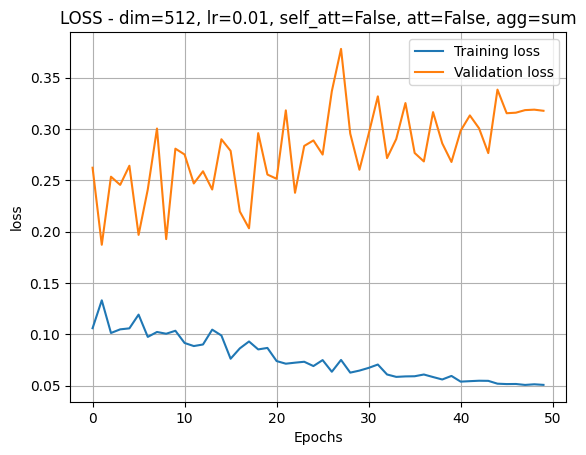

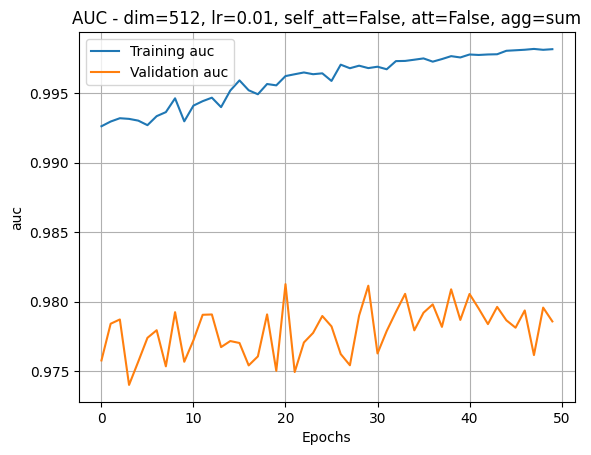

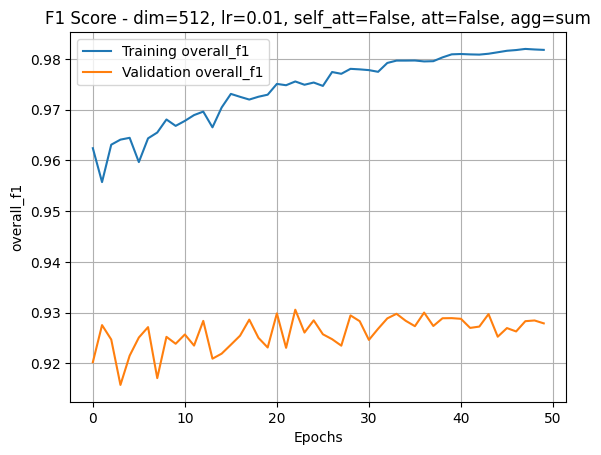

Entrenando el modelo con dim=512 lr=0.01, self_att=False, att=True, agg=sum
Params to be trained: 3859457
Train epoch 1
Pérdida de entrenamiento: 0.1088
Overall F1: 0.9616, AUC: 0.9926, Max Precision: 1.0000, Max Recall: 0.1999, Gain: 2399651
Test epoch 1
Pérdida de prueba: 0.2312
Overall F1: 0.9178, AUC: 0.9768, Max Precision: 1.0000, Max Recall: 0.1998, Gain: -8138637
Learning rate: 0.01 

Train epoch 2
Pérdida de entrenamiento: 0.1141
Overall F1: 0.9597, AUC: 0.9924, Max Precision: 0.9998, Max Recall: 0.1998, Gain: 3632564
Test epoch 2
Pérdida de prueba: 0.1868
Overall F1: 0.9278, AUC: 0.9794, Max Precision: 1.0000, Max Recall: 0.1988, Gain: -9326934
Learning rate: 0.01 

Train epoch 3
Pérdida de entrenamiento: 0.1056
Overall F1: 0.9627, AUC: 0.9928, Max Precision: 1.0000, Max Recall: 0.1998, Gain: 1618692
Test epoch 3
Pérdida de prueba: 0.2430
Overall F1: 0.9245, AUC: 0.9784, Max Precision: 1.0000, Max Recall: 0.1998, Gain: -12171490
Learning rate: 0.01 

Train epoch 4
Pérdida de e

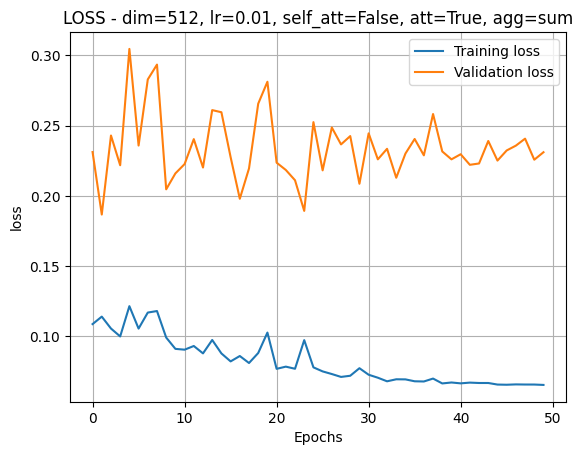

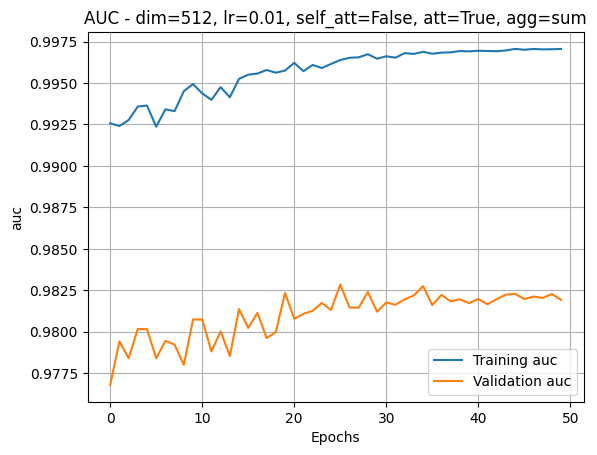

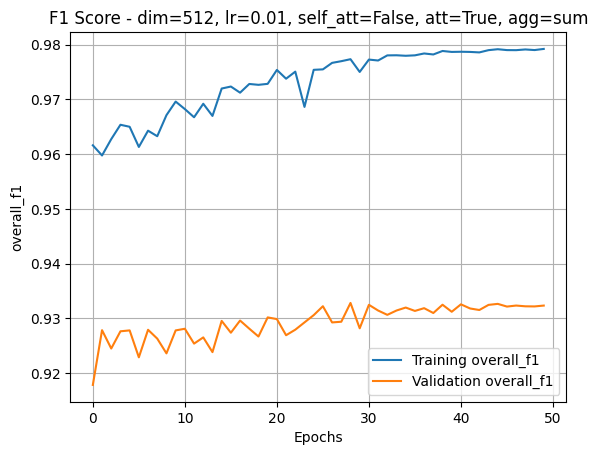

Entrenando el modelo con dim=512 lr=0.01, self_att=True, att=False, agg=sum
Params to be trained: 3859457
Train epoch 1
Pérdida de entrenamiento: 0.6933
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 1
Pérdida de prueba: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 2
Pérdida de entrenamiento: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 2
Pérdida de prueba: 0.6933
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 3
Pérdida de entrenamiento: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 3
Pérdida de prueba: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 4
Pérdida de entre

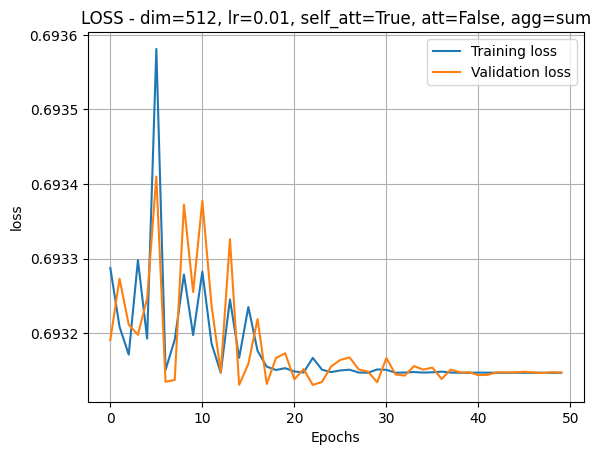

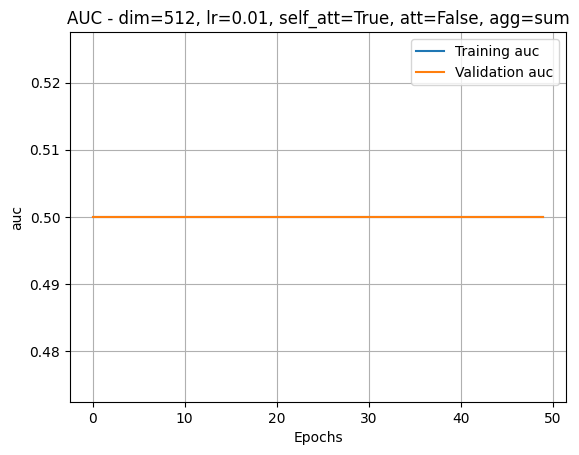

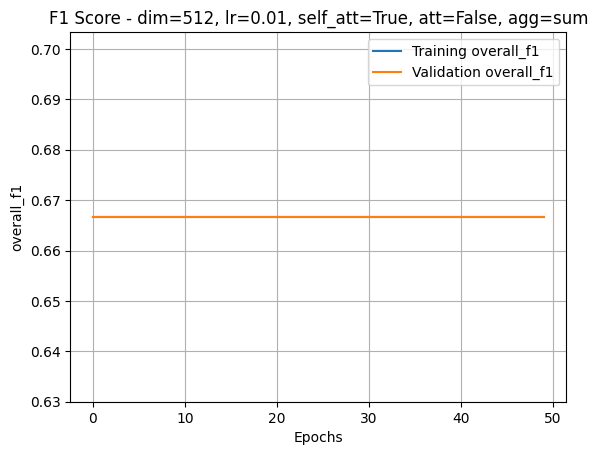

Entrenando el modelo con dim=512 lr=0.01, self_att=True, att=True, agg=sum
Params to be trained: 3859457
Train epoch 1
Pérdida de entrenamiento: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 1
Pérdida de prueba: 0.6931
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 2
Pérdida de entrenamiento: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 2
Pérdida de prueba: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 3
Pérdida de entrenamiento: 0.6932
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2788087
Test epoch 3
Pérdida de prueba: 0.6931
Overall F1: 0.6667, AUC: 0.5000, Max Precision: 0.0000, Max Recall: 0.0000, Gain: 2785930
Learning rate: 0.01 

Train epoch 4
Pérdida de entren

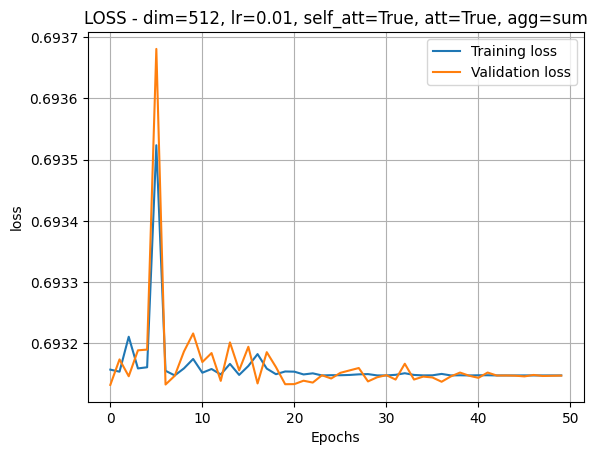

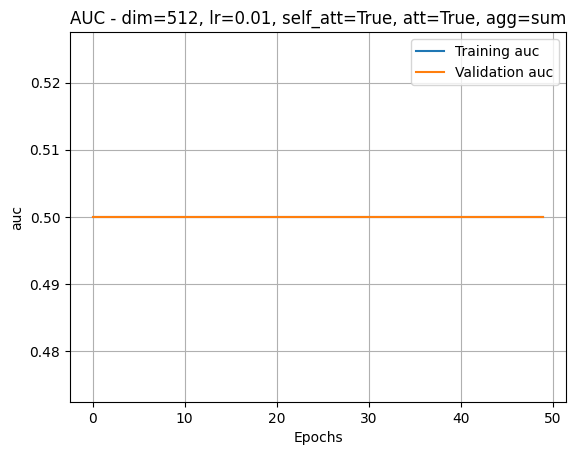

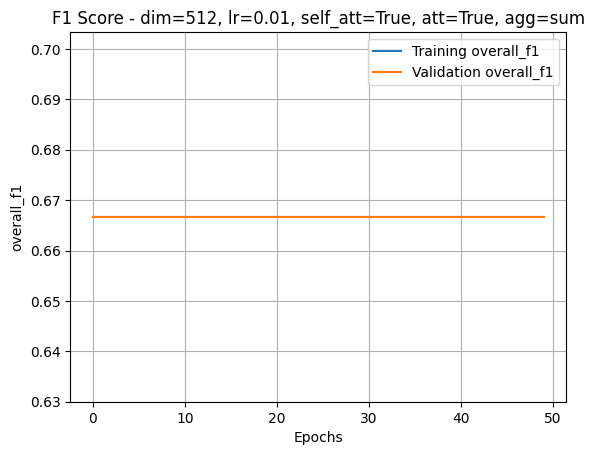

Entrenando el modelo con dim=512 lr=0.05, self_att=False, att=False, agg=sum
Params to be trained: 3859457
Train epoch 1
Pérdida de entrenamiento: 50.0016


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [ ]:
import itertools
import time

args.epoch = 50

dim_list = [254, 128]

lr_list = [0.01, 0.05]
self_att_list = [False, True]
att_list = [False, True]
agg_list = ["sum"]

combinations = list(itertools.product(dim_list, lr_list, self_att_list, att_list, agg_list))

results = []

def calculate_slope(history):
    epochs = list(range(1, len(history)+1))
    coef = np.polyfit(epochs, history, 1)[0]
    return coef

for dim, lr, self_att, att, agg in combinations:
    # Información del modelo
    curr_time = str(int(time.time()))
    model_name = f"DMEyF_ensamble_dim{dim}_lr{lr}_self{self_att}_att{att}_agg{agg}"
    model_path = f"modelos/{model_name}_{curr_time}.pkl"
    
    print(f"Entrenando el modelo con dim={dim} lr={lr}, self_att={self_att}, att={att}, agg={agg}")
    
    # Entrenamos el modelo
    model, history = train(
        train_loader,
        test_loader,
        args,
        show_steps=False,
        dim=dim,
        lr=lr,
        self=self_att,
        att=att,
        agg=agg
    )
    
    # Guardamos el modelo entrenado
    torch.save(model.state_dict(), model_path)

    # Extraemos las métricas de entrenamiento y validación
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_f1 = history['overall_f1']
    val_f1 = history['val_overall_f1']
    train_gain = history['gain']
    val_gain = history['val_gain']
    
    # Calculamos la pendiente de la pérdida de entrenamiento y validación
    train_loss_slope = calculate_slope(train_loss)
    val_loss_slope = calculate_slope(val_loss)
    
    # Calculamos la pendiente de la f1 de entrenamiento y validación
    train_f1_slope = calculate_slope(train_f1)
    val_f1_slope = calculate_slope(val_f1)

    # Calculamos la pendiente de la ganancia de entrenamiento y validación
    train_gain_slope = calculate_slope(train_gain)
    val_gain_slope = calculate_slope(val_gain)
    
    # Calculamos el promedio final de F1 Score
    final_train_f1 = train_f1[-1]
    final_val_f1 = val_f1[-1]

    # Calculamos el promedio final de ganancia
    final_train_gain = train_gain[-1]
    final_val_gain = val_gain[-1]
    
    # Almacenamos las métricas en un diccionario
    result = {
        'model_name': model_name,
        'dim': dim,
        'lr': lr,
        'self_att': self_att,
        'att': att,
        'agg': agg,
        'train_loss_slope': train_loss_slope,
        'val_loss_slope': val_loss_slope,
        'train_f1_slope': train_f1_slope,
        'val_f1_slope': val_f1_slope,
        'train_gain_slope': train_gain_slope,
        'val_gain_slope': val_gain_slope,
        'final_train_f1': final_train_f1,
        'final_val_f1': final_val_f1,
        'final_train_gain': final_train_gain,
        'final_val_gain': final_val_gain,
    }
    
    results.append(result)
    
    # Graficamos las métricas
    plot_metric(history, 'loss', title=f'LOSS - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')
    plot_metric(history, 'auc', title=f'AUC - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')
    plot_metric(history, 'overall_f1', title=f'F1 Score - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')

# Convertimos los resultados en un DataFrame
results_df = pd.DataFrame(results)

# Guardamos el DataFrame en un archivo CSV
results_df.to_csv('dl_att_exp_training_results.csv', index=False)

# Mostramos el DataFrame
print(results_df)

### 8. Armado del modelo predictivo hídrido

Usando el bosque y combinado con el modelo dl_att

In [ ]:
class HybridModel:
    def __init__(self, xgb_model_path, dl_model_path):
        # Load pre-trained XGBoost model for preprocessing
        self.xgb_clf = joblib.load(xgb_model_path)
        
        # Load pre-trained deep learning model for cross-feature embeddings
        self.dl_model = torch.load(dl_model_path)
        self.dl_model.eval()
        
    def process_leaf_idx(self, X_leaves):
        """
        This function is to convert the output of XGBoost model to the input of the deep learning model.
        """
        leaves = X_leaves.copy()
        new_leaf_index = dict()  # Dictionary to store leaf index
        total_leaves = 0
        for c in range(X_leaves.shape[1]):  # Iterate for each column (i.e. 100 trees)
            column = X_leaves[:, c]
            unique_vals = list(sorted(set(column)))
            new_idx = {v: (i + total_leaves) for i, v in enumerate(unique_vals)}
            for i, v in enumerate(unique_vals):
                leaf_id = i + total_leaves
                new_leaf_index[leaf_id] = {c: v}
            leaves[:, c] = [new_idx[v] for v in column]
            total_leaves += len(unique_vals)

        assert leaves.ravel().max() == total_leaves - 1
        return leaves, total_leaves, new_leaf_index

    def get_dataloader(self, X, batch_size=128):
        # Get leaf index from XGBoost model
        X_leaves = self.xgb_clf.apply(X)
        
        # Process leaf indexes
        transformed_leaves, _, _ = self.process_leaf_idx(X_leaves)

        print(transformed_leaves)
        
        # Convert to torch tensor
        transformed_leaves = torch.tensor(transformed_leaves).long()
        
        # Create dataset and dataloader
        x_dataset = Data.TensorDataset(transformed_leaves)
        x_loader = Data.DataLoader(dataset=x_dataset, batch_size=batch_size, shuffle=False)
        
        return x_loader

    def predict_proba(self, X):
        # Get dataloader for input data
        dataloader = self.get_dataloader(X)
        
        # Predict probabilities
        probabilities = []
        with torch.no_grad():
            for batch in dataloader:
                batch_input = batch[0]
                batch_output = self.dl_model(batch_input)[0]  # Extract tensor from tuple
                probs = torch.sigmoid(batch_output).squeeze().cpu().numpy()
                probabilities.extend(probs)
        
        return np.array(probabilities)

    def predict(self, X, threshold=0.5):
        # Predict probabilities
        probas = self.predict_proba(X)
        
        # Convert probabilities to binary predictions based on threshold
        predictions = (probas >= threshold).astype(int)

        return predictions
    
    def count_parameters(self):
        return sum(p.numel() for p in self.dl_model.parameters() if p.requires_grad)


Prueba del modelo híbrido

In [52]:
model_path

'modelos/DMEyF_ensamble1730213111.7074957.pkl'

In [55]:
xgb_model_path = 'modelos/xgb_classifier_model.pkl'
dl_model_path = 'modelos/DMEyF_ensamble1730213111.7074957.pkl'

# Instantiate the HybridModel
hybrid_model = HybridModel(xgb_model_path, dl_model_path)

# junio como mes de test
mes_test = 202106

X_ = data[data['foto_mes'] == mes_test]

target_multi = 'clase_ternaria'
X_ = X_.drop(columns=[target_multi])

# Predict probabilities
probas = hybrid_model.predict_proba(X_)
print(probas)

# Predict classes
predictions = hybrid_model.predict(X_)
print(predictions)

C:\Users\santt\AppData\Local\Temp\ipykernel_3380\3333257976.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dl_model = torch.load(dl_model_path)


[[  10.   26.   42. ... 1831. 1852. 1866.]
 [   5.   36.   53. ... 1842. 1852. 1866.]
 [   7.   21.   40. ... 1836. 1853. 1866.]
 ...
 [  10.   25.   46. ... 1831. 1856. 1868.]
 [  12.   29.   46. ... 1837. 1852. 1866.]
 [   9.   26.   49. ... 1836. 1856. 1866.]]
[0.5024309 0.5024309 0.5024309 ... 0.5024309 0.5024309 0.5024309]
[[  10.   26.   42. ... 1831. 1852. 1866.]
 [   5.   36.   53. ... 1842. 1852. 1866.]
 [   7.   21.   40. ... 1836. 1853. 1866.]
 ...
 [  10.   25.   46. ... 1831. 1856. 1868.]
 [  12.   29.   46. ... 1837. 1852. 1866.]
 [   9.   26.   49. ... 1836. 1856. 1866.]]
[1 1 1 ... 1 1 1]


In [50]:
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
hybrid_model.count_parameters()

71505

____

#### B. Entrenamiento de prueba

Sin self_att no att

Agg mean

Params to be trained: 115049
Train at epoch 1
Pérdida: 0.0937
Test at epoch 1
Pérdida: 0.1040
Ganancia: 40181386000.00
Learning rate [0.01] 

Train at epoch 2
Pérdida: 0.1050
Test at epoch 2
Pérdida: 0.0851
Ganancia: 40092570000.00
Learning rate [0.01] 

Train at epoch 3
Pérdida: 0.0923
Test at epoch 3
Pérdida: 0.1079
Ganancia: 40126268000.00
Learning rate [0.01] 

Train at epoch 4
Pérdida: 0.0983
Test at epoch 4
Pérdida: 0.1179
Ganancia: 40219893000.00
Learning rate [0.01] 

Train at epoch 5
Pérdida: 0.1190
Test at epoch 5
Pérdida: 0.0782
Ganancia: 40179853000.00
Learning rate [0.01] 

Train at epoch 6
Pérdida: 0.0938
Test at epoch 6
Pérdida: 0.1508
Ganancia: 40169325000.00
Learning rate [0.01] 

Train at epoch 7
Pérdida: 0.1012
Test at epoch 7
Pérdida: 0.1737
Ganancia: 40209288000.00
Learning rate [0.01] 

Train at epoch 8
Pérdida: 0.0881
Test at epoch 8
Pérdida: 0.1274
Ganancia: 40183311000.00
Learning rate [0.01] 

Train at epoch 9
Pérdida: 0.0972
Test at epoch 9
Pérdida: 0.1645
Ga

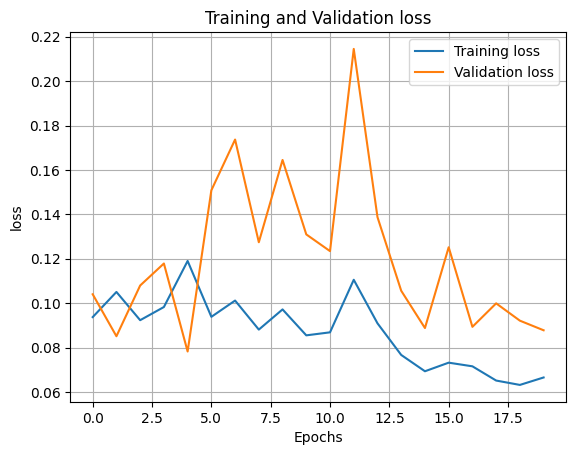

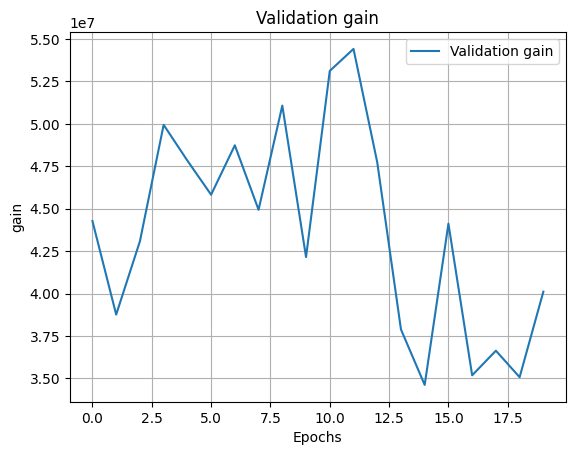

In [ ]:
import time

# Model information
curr_time = str(time.time())
model_name = "DMEyF_ensamble_no_self_no_att"
model_path = "modelos/%s%s.pkl" % (model_name, curr_time)

# increasing the numbers of epochs
args.epoch = 20

model, history = train(args, show_steps=False, dim=32, 
                       lr=0.01, self=False, att=False, agg="sum")

plot_metric(history, 'loss')
plot_metric(history, 'gain', train=False)

# torch.save(model, model_path)

In [ ]:
model_path

In [ ]:
xgb_model_path = 'modelos/xgb_classifier_model.pkl'
dl_model_path = 'modelos/DMEyF_ensamble1730213111.7074957.pkl'

# Instantiate the HybridModel
hybrid_model = HybridModel(xgb_model_path, dl_model_path)

# junio como mes de test
mes_test = 202106

X_ = data[data['foto_mes'] == mes_test]

target_multi = 'clase_ternaria'
X_ = X_.drop(columns=[target_multi])

# Predict probabilities
probas = hybrid_model.predict_proba(X_)
print(probas)

# Predict classes
predictions = hybrid_model.predict(X_)
print(predictions)